<a href="https://colab.research.google.com/github/qmeng222/transformers-for-NLP/blob/main/implement-transformers-from-scratch/encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Challenges:
*   Context switching from HF API to implementing in PyTorch
*   Build the multihead attention (MHA) and positional encoding
*   Train from scratch (no fine-tuning)

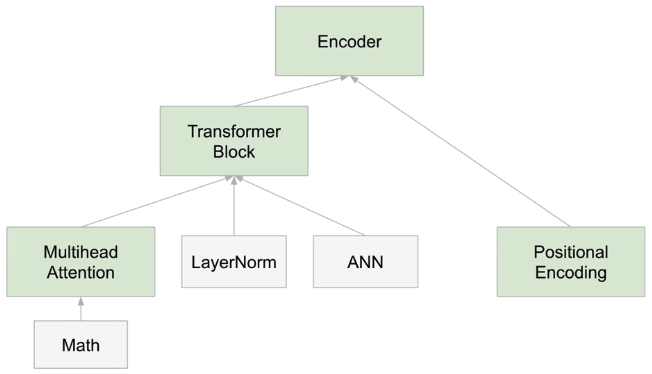

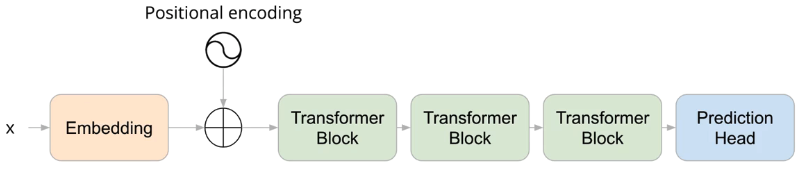

In [1]:
import math # Python math module provides mathematical functions

import torch # PyTorch library (a popular DL framework)
import torch.nn as nn # (from PyTorch library) neural network module for building and training neural networks
import torch.nn.functional as F # (within nn module) functional submodule provides functions (such as activation functions, loss functions, and other operations) that are applied element-wise to tensors
from torch.utils.data import Dataset # Dataset class to customize datasets for training

import numpy as np # NumPy library for numerical operations in Python
import matplotlib.pyplot as plt # (from Matplotlib library) pyplot module for data visualization

# Implement the multi head attention (MHA):

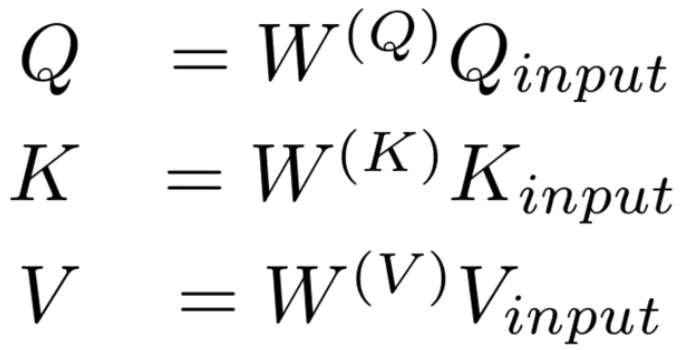

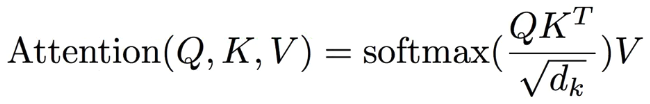

In [2]:
# define a class that inherits from nn.Module for MHA:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads):
    # d_k: dim of key vector for each attention head
    # d_model: dim of model input
    # n_heads: num of attention heads
    super().__init__()

    self.d_k = d_k # assume d_v = d_k (so no need to pass in d-V as well)
    self.n_heads = n_heads

    # create 3 linear layers to project the input (q, k, v) into the multi-head space:
    self.key = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)

    # final linear layer that projects the concatenated multi-head outputs back to the original space:
    self.fc = nn.Linear(d_k * n_heads, d_model)

  def forward(self, k, v, q, mask=None): # take k, v, q tensors as inputs
    k = self.key(k)   # N x T x (hd_k)
    v = self.value(v) # N x T x (hd_v)
    q = self.query(q) # N x T x (hd_k)

    N = q.shape[0]
    T = q.shape[1]

    # reshape: (N, T, h, d_k) -> (N, h, T, d_k), h is # of attention heads
    # swap the 2nd and 3rd dimensions (T and h), in order for matrix multiply to work properly
    q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

    # compute attn_weights: softmax[ QK^T / sqrt(d_k) ]
    # (N, h, T, d_k) x (N, h, d_k, T) --> (N, h, T, T)
    attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k) # `transpose(-2, -1)` swaps the last two dimensions (T and d_k)
    # if a mask tensor (a tensor of 0s and 1s) is provided, mask certain positions in the attention scores:
    if mask is not None:
      attn_scores = attn_scores.masked_fill(
          mask[:, None, None, :] == 0, float('-inf'))
    attn_weights = F.softmax(attn_scores, dim=-1) # apply the softmax function to the attn_scores tensor along the last dimension

    # compute attention-weighted values
    # (N, h, T, T) x (N, h, T, d_k) --> (N, h, T, d_k)
    A = attn_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1, 2) # (N, T, h, d_k)
    A = A.contiguous().view(N, T, self.d_k * self.n_heads) # (N, T, h*d_k)

    # projection layer
    return self.fc(A)

# Implement the transformer block:

In [3]:
# define a class that inherits from nn.Module:
class TransformerBlock(nn.Module):
  # initialize the TransformerBlock class with the following parameters:
  # d_k: dimensionality of the key vectors in the multi-head attention (MHA)
  # d_model: dimensionality of the input and output vectors
  # n_heads: num of attention heads in the multi-head attention (MHA)
  # dropout_prob: probability of dropout (default is 0.1)
  def __init__(self, d_k, d_model, n_heads, dropout_prob=0.1):
    super().__init__()

    # 1. create layer normalization (ln) modules & assign each module to an attribute:
    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)

    # 2. create an instance of the previously defined MultiHeadAttention class & assign it to an attribute:
    self.mha = MultiHeadAttention(d_k, d_model, n_heads)

    # 3. create a feedforward neural (FFN) network using nn.Sequential with the following layers:
    self.ann = nn.Sequential(
        nn.Linear(d_model, d_model * 4), # linear layer with an input size of d_model and output size of d_model * 4
        nn.GELU(), # GELU activation function
        nn.Linear(d_model * 4, d_model), # linear layer with an input size of d_model * 4 and output size of d_model
        nn.Dropout(dropout_prob), # dropout layer with the specified dropout probability
    )

    # 4. create a dropout layer with the specified dropout probability & assigns it to an attribute:
    self.dropout = nn.Dropout(p=dropout_prob)

  # define the forward pass for the TransformerBlock:
  def forward(self, x, mask=None):
    x = self.ln1(x + self.mha(x, x, x, mask)) # layer normalization + MHA operation
    x = self.ln2(x + self.ann(x)) # layer normalization + FNN operation
    x = self.dropout(x) # dropout operation
    return x # return the final res after applying layer normalization, multi-head attention, feedforward network, and dropout